## **SKENARIO 1: Klasifikasi VBNN - Feature Selection**

## **IMPORT LIBRARY**

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import time
from collections import namedtuple
from matplotlib.lines import Line2D
from scipy.spatial import Voronoi, voronoi_plot_2d

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [79]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [80]:
# Menggabungkan fitur train dan label 
print(f"Data Train Loaded\nDimension: {df_train.shape}")

Data Train Loaded
Dimension: (3817, 16)


## **FEATURE ENGINEERING**

### - **Split Data**

In [81]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(df_train, df_label, test_size=0.2, random_state=42, stratify=df_label)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 16), Val Shape: (764, 16)


In [82]:
# Mempersiapkan Data Testing
X_test_raw = df_test.drop(columns=['ID'])
print(f"Data Test Loaded\nDimension: {X_test_raw.shape}")

Data Test Loaded
Dimension: (3818, 16)


In [83]:
X_train_raw.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
2329,1962,Doktor,Cerai,170435626.0,0.0,0.0,29.0,62713.0,925837.0,117753.0,151245.0,1.0,4.0,12.0,0.0,NaN
394,1973,Doktor,Rencana Menikah,171014909.0,0.0,0.0,79.0,189937.0,1166661.0,164325.0,84866.0,0.0,5.0,6.0,0.0,NaN
981,1951,Sarjana,Rencana Menikah,98962000.0,0.0,1.0,36.0,26299.0,159817.0,12138.0,24276.0,5.0,6.0,6.0,1.0,2013-01-14
1199,1966,Sarjana,Sendiri,93386407.0,0.0,1.0,38.0,10163.0,48697.0,10870.0,2632.0,4.0,NaN,4.0,0.0,NaN
3137,1959,Sarjana,Menikah,150100639.0,0.0,NaN,46.0,127193.0,307425.0,90571.0,44549.0,NaN,7.0,8.0,0.0,NaN


In [84]:
X_val_raw.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
2464,1957,Sarjana,Sendiri,33742926.0,0.0,0.0,79.0,8109.0,25610.0,8792.0,5398.0,3.0,NaN,NaN,0.0,NaN
480,1976,Sarjana,Rencana Menikah,140988476.0,0.0,NaN,45.0,102826.0,804331.0,52446.0,44966.0,0.0,6.0,5.0,0.0,NaN
2368,1979,Sarjana,NaN,29604689.0,1.0,0.0,57.0,0.0,6331.0,16100.0,12090.0,1.0,0.0,0.0,0.0,NaN
3457,1977,Sarjana,Rencana Menikah,118810462.0,0.0,1.0,60.0,30193.0,172971.0,85239.0,72449.0,2.0,8.0,6.0,0.0,NaN
503,1972,Sarjana,Sendiri,129913133.0,0.0,0.0,49.0,30597.0,551015.0,29839.0,49816.0,4.0,2.0,8.0,0.0,NaN


In [85]:
X_test_raw.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1957,Sarjana,NaN,120660151.0,0.0,1.0,63.0,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,NaN
1,1968,Doktor,Menikah,163551821.0,0.0,1.0,58.0,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,NaN
2,1968,SMA,Menikah,29857000.0,0.0,0.0,34.0,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06
3,1971,Doktor,Menikah,117949098.0,0.0,1.0,82.0,4872.0,126061.0,0.0,9745.0,3.0,5.0,7.0,0.0,NaN
4,1974,Sarjana,Rencana Menikah,164761134.0,0.0,0.0,28.0,343208.0,1416462.0,236196.0,107776.0,0.0,1.0,8.0,0.0,NaN


### - **Missing Value Handling**

In [86]:
# Ganti noise '5' dengan NaN agar dianggap missing value
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()
X_test_clean = X_test_raw.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    X_train_clean[col] = X_train_clean[col].replace('5', np.nan)
    X_val_clean[col] = X_val_clean[col].replace('5', np.nan)
    X_test_clean[col] = X_test_clean[col].replace('5', np.nan)

In [87]:
num_cols = X_train_clean.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train_clean.select_dtypes(include=['object']).columns

In [88]:
# Imputasi Missing Values


# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])
X_test_clean[num_cols] = imputer_num.transform(X_test_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])
X_test_clean[cat_cols] = imputer_cat.transform(X_test_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)
X_test_imp = pd.DataFrame(X_test_clean, columns=X_test_clean.columns, index=X_test_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [89]:
X_train_imp.isna().sum()

tahun_kelahiran            0
pendidikan                 0
status_pernikahan          0
pendapatan                 0
jumlah_anak_balita         0
jumlah_anak_remaja         0
terakhir_belanja           0
belanja_buah               0
belanja_daging             0
belanja_ikan               0
belanja_kue                0
pembelian_diskon           0
pembelian_web              0
pembelian_toko             0
keluhan                    0
tanggal_menjadi_anggota    0
dtype: int64

In [90]:
X_val_imp.isna().sum()

tahun_kelahiran            0
pendidikan                 0
status_pernikahan          0
pendapatan                 0
jumlah_anak_balita         0
jumlah_anak_remaja         0
terakhir_belanja           0
belanja_buah               0
belanja_daging             0
belanja_ikan               0
belanja_kue                0
pembelian_diskon           0
pembelian_web              0
pembelian_toko             0
keluhan                    0
tanggal_menjadi_anggota    0
dtype: int64

In [91]:
X_test_imp.isna().sum()

tahun_kelahiran            0
pendidikan                 0
status_pernikahan          0
pendapatan                 0
jumlah_anak_balita         0
jumlah_anak_remaja         0
terakhir_belanja           0
belanja_buah               0
belanja_daging             0
belanja_ikan               0
belanja_kue                0
pembelian_diskon           0
pembelian_web              0
pembelian_toko             0
keluhan                    0
tanggal_menjadi_anggota    0
dtype: int64

### - **Feature Creation**

In [92]:
X_train_fc = X_train_imp.copy()
X_val_fc = X_val_imp.copy()
X_test_fc = X_test_imp.copy()

def feature_creation(df_in):
    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = 2024 - df_out['tahun_kelahiran']

    # 3. Feature: Lama Bergabung
    df_out['lama_bergabung_hari'] = (pd.Timestamp('2024-01-01') - df_out['tanggal_menjadi_anggota']).dt.days
    df_out['lama_bergabung_hari'] = df_out['lama_bergabung_hari'].fillna(0)
    
    # 3. Feature: is_member
    df_out['is_member'] = df_out['tanggal_menjadi_anggota'].notna().astype(int)
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

X_train_fc = feature_creation(X_train_fc)
X_val_fc = feature_creation(X_val_fc)
X_test_fc = feature_creation(X_test_fc)

print(f"Feature Creation Selesai\nTrain Dimension: {X_train_fc.shape}")
print(f"Feature Creation Selesai\nValidation Dimension: {X_val_fc.shape}")
print(f"Feature Creation Selesai\nDimension: {X_test_fc.shape}")

Feature Creation Selesai
Train Dimension: (3053, 18)
Feature Creation Selesai
Validation Dimension: (764, 18)
Feature Creation Selesai
Dimension: (3818, 18)


In [93]:
X_train_fc.head()

,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,is_member,total_belanja
2329,Doktor,Cerai,170435626.0,0.0,0.0,29.0,62713.0,925837.0,117753.0,151245.0,1.0,4.0,12.0,0.0,62.0,4069,1,1257548.0
394,Doktor,Rencana Menikah,171014909.0,0.0,0.0,79.0,189937.0,1166661.0,164325.0,84866.0,0.0,5.0,6.0,0.0,51.0,4069,1,1605789.0
981,Sarjana,Rencana Menikah,98962000.0,0.0,1.0,36.0,26299.0,159817.0,12138.0,24276.0,5.0,6.0,6.0,1.0,73.0,4004,1,222530.0
1199,Sarjana,Sendiri,93386407.0,0.0,1.0,38.0,10163.0,48697.0,10870.0,2632.0,4.0,4.0,4.0,0.0,58.0,4069,1,72362.0
3137,Sarjana,Menikah,150100639.0,0.0,0.0,46.0,127193.0,307425.0,90571.0,44549.0,2.0,7.0,8.0,0.0,65.0,4069,1,569738.0


### - **FEATURE SELECTION**

In [94]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import f1_score
# import pandas as pd

# # Model dasar
# knn = KNeighborsClassifier(
#     n_neighbors=1,
#     weights="uniform",
#     metric="manhattan"
# )

# # Sequential Feature Selector
# sfs = SequentialFeatureSelector(
#     estimator=knn,
#     n_features_to_select=18,     # jumlah fitur akhir
#     direction="forward",         # forward selection
#     scoring="f1_macro",          # sesuai task classification
#     cv=3,                        # cross-validation di TRAIN
#     n_jobs=-1
# )

# # FIT HANYA di data TRAIN
# sfs.fit(X_train_fc, y_train)

# # Boolean mask fitur terpilih
# selected_mask = sfs.get_support()

# # Nama fitur
# selected_features = X_train_fc.columns[selected_mask].tolist()

# print("Selected Features (Wrapper SFS):")
# print(selected_features)

# # Dataset final
# X_train_fs = X_train_fc[selected_features]
# X_val_fs = X_val_fc[selected_features]
# X_test_fs = X_test_fc[selected_features]

# print("Feature Selection Done\nTrain shape:", X_train_fs.shape)
# print("Feature Selection Done\nValidation shape:", X_val_fs.shape)
# print("Feature Selection Done\nTest shape:", X_test_fs.shape)

In [95]:
X_train_fs = X_train_fc.copy()
X_val_fs = X_val_fc.copy()
X_test_fs = X_test_fc.copy()

def feature_selection(df_in):
    selected_features = [
        "umur",
        "status_pernikahan",
        "is_member",
        "lama_bergabung_hari",
        "terakhir_belanja",
        "total_belanja",
        "pembelian_diskon",
        "pembelian_web",
        "pembelian_toko",
        "keluhan",
        "jumlah_anak_balita",
        "jumlah_anak_remaja"
    ]
    df_out = df_in[selected_features]
    return df_out

X_train_fs = feature_selection(X_train_fs)
X_val_fs = feature_selection(X_val_fs)
X_test_fs = feature_selection(X_test_fs)

print(f"Feature Selection Selesai\nTrain Dimension: {X_train_fs.shape}")
print(f"Feature Selection Selesai\nValidation Dimension: {X_val_fs.shape}")
print(f"Feature Selection Selesai\nTest Dimension: {X_test_fs.shape}")

Feature Selection Selesai
Train Dimension: (3053, 12)
Feature Selection Selesai
Validation Dimension: (764, 12)
Feature Selection Selesai
Test Dimension: (3818, 12)


In [96]:
X_train_fs.head()

,umur,status_pernikahan,is_member,lama_bergabung_hari,terakhir_belanja,total_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_anak_balita,jumlah_anak_remaja
2329,62.0,Cerai,1,4069,29.0,1257548.0,1.0,4.0,12.0,0.0,0.0,0.0
394,51.0,Rencana Menikah,1,4069,79.0,1605789.0,0.0,5.0,6.0,0.0,0.0,0.0
981,73.0,Rencana Menikah,1,4004,36.0,222530.0,5.0,6.0,6.0,1.0,0.0,1.0
1199,58.0,Sendiri,1,4069,38.0,72362.0,4.0,4.0,4.0,0.0,0.0,1.0
3137,65.0,Menikah,1,4069,46.0,569738.0,2.0,7.0,8.0,0.0,0.0,0.0


### - **FEATURE TRANSFORMATION**

#### Outlier Handling

In [97]:
# Handling Outliers 
X_train_oh = X_train_fs.copy()
X_val_oh = X_val_fs.copy()
X_test_oh = X_test_fs.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_oh.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_oh[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_oh[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_oh[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_oh[col] < mild_l) | (X_train_oh[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_oh[col] < ext_l) | (X_train_oh[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_oh[col] < vext_l) | (X_train_oh[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,umur,0.491320,0.131019,0.000000
1,is_member,0.000000,0.000000,0.000000
2,lama_bergabung_hari,27.906977,27.906977,27.906977
3,terakhir_belanja,0.000000,0.000000,0.000000
4,total_belanja,1.277432,0.000000,0.000000
5,pembelian_diskon,3.832296,0.425811,0.131019
6,pembelian_web,0.556829,0.065509,0.065509
7,pembelian_toko,0.294792,0.000000,0.000000
8,keluhan,0.556829,0.556829,0.556829
9,jumlah_anak_balita,0.000000,0.000000,0.000000


In [98]:
cols_to_winsor = outlier_df.loc[
    (outlier_df["extreme_outlier_pct (%)"] > 0) |
    (outlier_df["very_extreme_outlier_pct (%)"] > 0),
    "feature"
].tolist()


winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_oh[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_oh[col] = X_train_oh[col].clip(lower, upper)
    X_val_oh[col] = X_val_oh[col].clip(lower, upper)
    X_test_oh[col] = X_test_oh[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


#### Encoding

In [99]:
# Melakukan encoding
X_train_enc = X_train_oh.copy()
X_val_enc = X_val_oh.copy()
X_test_enc = X_test_oh.copy()

# Nominal Fitur -> One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_test_enc = pd.get_dummies(X_test_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [100]:
X_train_enc.head()

,umur,is_member,lama_bergabung_hari,terakhir_belanja,total_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_anak_balita,jumlah_anak_remaja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2329,62.0,1,4069,29.0,1257548.0,1.0,4.0,12.0,0.0,0.0,0.0,1,0,0,0,0
394,51.0,1,4069,79.0,1605789.0,0.0,5.0,6.0,0.0,0.0,0.0,0,0,0,1,0
981,73.0,1,4069,36.0,222530.0,5.0,6.0,6.0,0.0,0.0,1.0,0,0,0,1,0
1199,58.0,1,4069,38.0,72362.0,4.0,4.0,4.0,0.0,0.0,1.0,0,0,0,0,1
3137,65.0,1,4069,46.0,569738.0,2.0,7.0,8.0,0.0,0.0,0.0,0,0,1,0,0


#### Scaling

In [101]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_enc),
    columns=X_train_enc.columns,
    index=X_train_enc.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_enc),
    columns=X_val_enc.columns,
    index=X_val_enc.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_enc),
    columns=X_test_enc.columns,
    index=X_test_enc.index
)

print("Scaling selesai")

Scaling selesai


In [102]:
X_train_scaled.head()

,umur,is_member,lama_bergabung_hari,terakhir_belanja,total_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_anak_balita,jumlah_anak_remaja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2329,0.352941,0.0,0.0,-0.428571,0.986201,-0.5,0.00,1.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
394,-0.294118,0.0,0.0,0.761905,1.366308,-1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
981,1.000000,0.0,0.0,-0.261905,-0.143528,1.5,0.50,0.25,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1199,0.117647,0.0,0.0,-0.214286,-0.307437,1.0,0.00,-0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3137,0.529412,0.0,0.0,-0.023810,0.235452,0.0,0.75,0.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [103]:
X_val_scaled.head()

,umur,is_member,lama_bergabung_hari,terakhir_belanja,total_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_anak_balita,jumlah_anak_remaja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2464,0.647059,0.0,0.0,0.761905,-0.334128,0.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
480,-0.470588,0.0,0.0,-0.047619,0.710073,-1.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2368,-0.647059,0.0,0.0,0.238095,-0.348741,-0.5,-1.0,-1.25,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3457,-0.529412,0.0,0.0,0.309524,0.007452,0.0,1.0,0.25,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
503,-0.235294,0.0,0.0,0.047619,0.335357,1.0,-0.5,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [104]:
X_test_scaled.head()

,umur,is_member,lama_bergabung_hari,terakhir_belanja,total_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_anak_balita,jumlah_anak_remaja,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
0,0.647059,0.0,0.0,0.380952,0.663797,1.0,0.50,1.25,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.0,0.0,0.261905,0.152318,0.0,0.25,1.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.0,0.0,-0.309524,-0.291472,0.0,-1.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.176471,0.0,0.0,0.833333,-0.232870,0.5,0.25,0.50,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.352941,0.0,0.0,-0.452381,1.909718,-1.0,-0.75,0.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## **MODELING**

In [25]:
Node = namedtuple('Node', ['point', 'label', 'left', 'right', 'axis'])

class CustomKDTree:
    def __init__(self, X, y):
        self.k = X.shape[1] 
        self.root = self._build_tree(X, y)

    def _build_tree(self, points, labels, depth=0):
        n = len(points)
        if n == 0:
            return None
        axis = depth % self.k
        
        # Gabungkan point dan label
        combined = list(zip(points, labels))
        combined.sort(key=lambda x: x[0][axis])
        mid = n // 2
        
        return Node(
            point=combined[mid][0],
            label=combined[mid][1],
            left=self._build_tree([p for p, l in combined[:mid]], 
                                  [l for p, l in combined[:mid]], depth + 1),
            right=self._build_tree([p for p, l in combined[mid+1:]], 
                                   [l for p, l in combined[mid+1:]], depth + 1),
            axis=axis
        )

    def _distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def _search_nearest(self, node, target, best=None):
        if node is None:
            return best

        dist = self._distance(node.point, target)

        # Update best: simpan (Jarak, Label, KOORDINAT_ASLI)
        if best is None or dist < best[0]:
            best = (dist, node.label, node.point) 

        axis = node.axis
        diff = target[axis] - node.point[axis]

        if diff < 0:
            near_node, far_node = node.left, node.right
        else:
            near_node, far_node = node.right, node.left

        best = self._search_nearest(near_node, target, best)

        if abs(diff) < best[0]:
            best = self._search_nearest(far_node, target, best)

        return best

    def query(self, X):
        """Hanya mengembalikan Label (Untuk evaluasi akurasi)"""
        predictions = []
        for x in X:
            # best = (jarak, label, point) -> ambil label index 1
            best_tuple = self._search_nearest(self.root, x)
            predictions.append(best_tuple[1]) 
        return np.array(predictions)
    
    def query_complete(self, x_single):
        """
        Fitur Khusus Visualisasi:
        Mengembalikan (Label, Koordinat_Tetangga)
        Menggunakan pencarian Tree murni.
        """
        # best = (jarak, label, point)
        best_tuple = self._search_nearest(self.root, x_single)
        return best_tuple[1], best_tuple[2] # Return Label dan Point

In [26]:
class VBNN:
    def __init__(self):
        self.voronoi = None       
        self.tree = None          
        self.X_train = None
        self.y_train = None
        self.dim = None  # Menyimpan info dimensi (2D/3D/dst)
        
    def fit(self, X, y):
        # --- 1. PERSIAPAN DATA (FLEXIBLE) ---
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.dim = self.X_train.shape[1] # Deteksi otomatis dimensi data
        
        print(f"Mendeteksi Data {self.dim} Dimensi.")
        
        # --- 2. KONSTRUKSI VORONOI (N-DIMENSI) ---
        # Scipy Voronoi menggunakan algoritma Quickhull (Dual dari Delaunay)
        # Ini bekerja untuk dimensi berapapun (2D, 3D, 4D...)
        # print("Membangun Diagram Voronoi (General N-D)...")
        # self.voronoi = Voronoi(self.X_train)
        # print("OK")
        
        # --- 3. MEMBANGUN K-D TREE ---
        print("Membangun k-d Tree...")
        self.tree = CustomKDTree(self.X_train, self.y_train)
        print("OK")
        
    def predict(self, X):
        # Pastikan dimensi input sama dengan dimensi training
        X = np.array(X)
        if X.shape[1] != self.dim:
            raise ValueError(f"Input harus {self.dim} dimensi, tapi mendapat {X.shape[1]}")
        return self.tree.query(X)

    def visualize(self):
        """
        Visualisasi Cerdas:
        - Otomatis memilih mode 2D atau 3D tergantung data.
        """
        if self.voronoi is None:
            print("Belum di-fit!")
            return

        if self.dim == 2:
            self._plot_2d()
        elif self.dim == 3:
            self._plot_3d()
        else:
            print(f"Maaf, visualisasi hanya support 2D dan 3D. Data Anda {self.dim}D.")

    # --- INTERNAL HELPER UNTUK 2D ---
    def _plot_2d(self):
        print("Mode Visualisasi: 2D")
        plt.figure(figsize=(10, 8))
        
        # Gambar Voronoi menggunakan helper scipy biar akurat
        # show_vertices=False biar titik sudut tidak menutupi data
        voronoi_plot_2d(self.voronoi, show_vertices=False, line_colors='#E67E22', 
                        line_width=2, line_alpha=0.6, point_size=2)
        
        # Timpa titik data dengan warna kita sendiri
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c='royalblue', s=30, zorder=5)
        
        plt.title("Visualisasi VBNN 2D (Flexible Engine)")
        plt.xlabel("X1"); plt.ylabel("X2")
        plt.tight_layout()
        plt.show()

    # --- INTERNAL HELPER UNTUK 3D ---
    def _plot_3d(self):
        print("Mode Visualisasi: 3D (Filtered Wireframe)")
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Auto-Zoom Logic
        x_min, x_max = self.X_train[:, 0].min(), self.X_train[:, 0].max()
        y_min, y_max = self.X_train[:, 1].min(), self.X_train[:, 1].max()
        z_min, z_max = self.X_train[:, 2].min(), self.X_train[:, 2].max()
        
        # Filter garis infinity (agar tidak seperti laba-laba)
        max_len = np.max([x_max-x_min, y_max-y_min, z_max-z_min]) * 0.4
        
        # Gambar Garis
        for simplex in self.voronoi.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):
                pts = self.voronoi.vertices[simplex]
                if np.linalg.norm(pts[0] - pts[1]) < max_len:
                    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], c='#E67E22', alpha=0.3, linewidth=0.5)

        # Gambar Titik
        ax.scatter(self.X_train[:, 0], self.X_train[:, 1], self.X_train[:, 2], 
                   c='royalblue', s=20, alpha=0.8)

        ax.set_title("Visualisasi VBNN 3D")
        ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max); ax.set_zlim(z_min, z_max)
        plt.show()

In [27]:
# Training Phase
model = VBNN()

print("===== TRAINING MODEL VBNN =====")
start_train = time.time()
model.fit(X_train_final.values, y_train.values)
print(f"Waktu Training: {time.time() - start_train:.4f} detik")

# Visualization Phase
# print("\n===== VISUALISASI DIAGRAM VORONOI =====")
# model.visualize()

===== TRAINING MODEL VBNN =====
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Waktu Training: 0.0310 detik


## **EVALUATION**

In [28]:
start_pred = time.time()
y_pred_vbnn = model.predict(X_val_final.values)
time_pred = time.time() - start_pred

f1_macro = f1_score(y_val.values, y_pred_vbnn, average="macro")
accuracy = accuracy_score(y_val.values, y_pred_vbnn)

print(f"Accuracy      : {accuracy * 100:.2f}%")
print(f"Macro F1 Score : {f1_macro * 100:.2f}%")
print(f"Waktu Prediksi : {time_pred:.4f} detik\n")

print("Classification Report:")
print(classification_report(y_val.values, y_pred_vbnn))

Accuracy      : 63.87%
Macro F1 Score : 64.51%
Waktu Prediksi : 4.1831 detik

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       195
           1       0.55      0.39      0.46       120
           2       0.54      0.57      0.55        79
           3       0.73      0.80      0.76        84
           4       0.65      0.88      0.74        91
           5       0.70      0.83      0.76       120
           6       0.71      0.68      0.69        75

    accuracy                           0.64       764
   macro avg       0.64      0.66      0.65       764
weighted avg       0.63      0.64      0.63       764



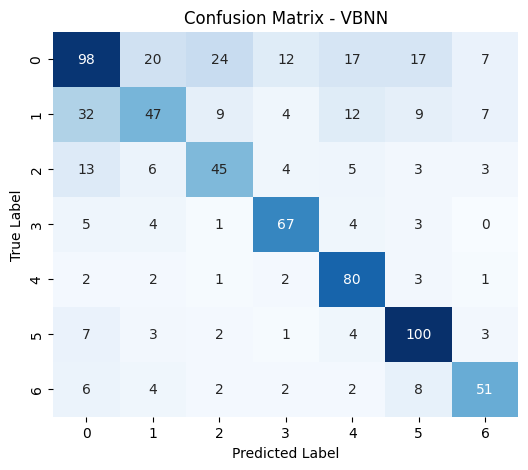

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_val.values, y_pred_vbnn)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VBNN")
plt.show()

In [30]:
# Cross-Validation 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_scores = []
acc_scores = []
pred_times = []

print("===== Cross Validation VBNN =====")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train), 1):
    X_tr, X_va = X_train_final.values[train_idx], X_train_final.values[val_idx]
    y_tr, y_va = y_train.values[train_idx], y_train.values[val_idx]

    model_cv = VBNN()
    model_cv.fit(X_tr, y_tr)

    start = time.time()
    y_pred = model_cv.predict(X_va)
    pred_time = time.time() - start

    f1 = f1_score(y_va, y_pred, average="macro")
    acc = accuracy_score(y_va, y_pred)

    # Simpan hasil
    f1_scores.append(f1)
    acc_scores.append(acc)
    pred_times.append(pred_time)

    # Tampilkan per fold
    print(
        f"Fold {fold:>2} | "
        f"Macro F1: {f1*100:6.2f}% | "
        f"Akurasi: {acc*100:6.2f}% | "
        f"Waktu Prediksi: {pred_time:.4f} detik"
    )

# Ringkasan
print("\n===== Ringkasan CV =====")
print(f"Macro F1 Mean : {np.mean(f1_scores)*100:.2f}%")
print(f"Macro F1 Std  : {np.std(f1_scores)*100:.2f}%")
print(f"Akurasi Mean : {np.mean(acc_scores)*100:.2f}%")
print(f"Akurasi Std  : {np.std(acc_scores)*100:.2f}%")
print(f"Avg Predict Time : {np.mean(pred_times):.4f} detik")

===== Cross Validation VBNN =====
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  1 | Macro F1:  59.36% | Akurasi:  60.56% | Waktu Prediksi: 2.5324 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  2 | Macro F1:  59.87% | Akurasi:  60.23% | Waktu Prediksi: 2.6032 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  3 | Macro F1:  59.98% | Akurasi:  60.72% | Waktu Prediksi: 3.1355 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  4 | Macro F1:  60.19% | Akurasi:  60.98% | Waktu Prediksi: 3.0741 detik
Mendeteksi Data 18 Dimensi.
Membangun k-d Tree...
OK
Fold  5 | Macro F1:  59.02% | Akurasi:  60.00% | Waktu Prediksi: 2.6093 detik

===== Ringkasan CV =====
Macro F1 Mean : 59.68%
Macro F1 Std  : 0.43%
Akurasi Mean : 60.50%
Akurasi Std  : 0.35%
Avg Predict Time : 2.7909 detik
